# Brakistokroneja

In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

## Tarvittavat Yhtälöt
Brakistokroniongelmassa kappale lähtee koordinaateista $(r_0, \phi_0)$ ja päätyy koordinaatteihin $(r_1, \phi_1)$. Vaaditaan, että $\phi_0 > \phi_1$ ja $r_0 = r_1$ (voitaisiin myös vaatia $r_0 \geq r_1$, mutta tällä valinnalla ratkaisukäyrät sisältäisivät vähemmän tietoa). Ongelman ratkaisu on käyrä, jota pitkin kitkattomasti liukuen kappale päätyy nopeiten päätepisteeseen.

Ratkaistaan numeerisesti brakistokronikäyrät Newtonin universaalille painovoimalaille sekä Schwarzschildin metriikassa. Kummassakin mallissa ratkaisukäyrät saadaan seuraavasta yhtälöryhmästä:

$$
\phi - \phi_0 = \begin{cases}
                       \int_{r_0}^{r(\phi)} I(r) dr, \hspace{3.5cm} \forall \phi \geq \phi (r_{min})\\
                       \int_{r_0}^{r_{min}} I(r) dr - \int_{r_{min}}^{r(\phi)} I(r) dr, \hspace{0.8cm} muutoin.
                   \end{cases}
$$

Ainut ero on integrandissa $I(r)$. Kun gravitaatiota kuvataan Newtonin gravitaatiopotentiaalilla $V = -GmM/r^2$, integrandi on muotoa

$$
I(r) = \frac{1}{r} \sqrt{\frac{r_0 - r}{Cr^3 + r - r_0}},
$$

missä $C$ määräytyy yksikäsitteisesti lopputilan $(r1, \phi_1)$ avulla:

$$ \phi_1 - \phi_0 = \int_{r_0}^{r_{min}} I(r) dr - \int_{r_{min}}^{r_1} I(r) dr $$

Pienin saavutettu säde $r_{min}$ saadaan yhtälöstä

$$
Cr_{min}^3 + r_{min} - r_0 = 0.
$$

Kun taas gravitaatiota kuvataan Schwarzschildin metriikalla, vastaava integrandi on

$$
I(r) = \dfrac{1}{r}\sqrt{\dfrac{r_0 - r}{Cr^3 + (r - r_0) \left(1 - \frac{R_s}{r}\right)}}.
$$

Vakio $C$ saadaan ratkaistua tismalleen samoin kuin edellä. Vakiolle $E$ pätee

$$ E = \sqrt{1 - \frac{R_s}{r_0}} $$

ja vakio $R_s$ on Schwarzschildin säde, joka voidaan valita mielivaltaisesti (rajoituksella $R_s < r_0$). Pienin saavutettu säde $r_{min}$ saadaan yhtälöstä

$$
Cr_{min}^3 + (r_{min} - r_0) \left(1 - \frac{R_s}{r_{min}}\right) = 0.
$$

Kummassakin tapauksessa $\phi(r_{min})$ saadaan yhtälöstä

$$
\phi(r_{min}) = \int_{r_0}^{r_{min}} I(r) dr + \phi_0.
$$


## Yhtälöiden ratkaiseminen

Ratkaistaan kummassakin tapauksessa säde $r$ kulman $\phi$ funktiona. Käytetään tähän Scipyn fsolve-funktiota, jolla voidaan etsiä kullekin $\phi$ sellainen $r$, että edellä esitetty käyrää kuvaava yhtälö toteutuu. Luodaan seuraavaksi eri vakioiden ratkaisemiseen tarvittavat funktiot. Erotellaan eri mallit lyhenteillä "schw" - Schwarzschildin metriikka ja "nwton" - Newtonin universaali painovoimalaki.

In [2]:
def integrand_nwton(r, r0, C):
    return 1 / r * np.sqrt((r0 - r) / (C * r**3 + r - r0))

In [3]:
def main_eq_nwton(r, r0, phi, phi0, r_min, phi_r_min, C):
    if (r < r_min): # Varmistetaan, ettei mennä kielletylle alueelle.
        return 1
    if (phi >= phi_r_min):
        return phi - phi0 - quad(integrand_nwton, r0, r, args=(r0, C))[0]
    else:
        return phi - phi0 - quad(integrand_nwton, r0, r_min, args=(r0, C))[0] + quad(integrand_nwton, r_min, r, args=(r0, C))[0]

In [4]:
def r_min_eq_nwton(r_min, C, r0):
    return C * r_min**3 + r_min - r0

In [5]:
def phi_r_min_nwton(r_min, phi1, C):
    return phi1 - quad(integrand_nwton, r0, r_min, args=(r0, C))[0]

In [6]:
def C_eq_nwton(C, r0, r1, phi0, phi1):
    r_min = fsolve(r_min_eq_nwton, r0 / 2, args=(C, r0))[0]
    
    return phi1 - phi0 - quad(integrand_nwton, r0, r_min, args=(r0, C))[0] + quad(integrand_nwton, r_min, r1, args=(r0, C))[0]


In [7]:
def calculate_R_nwton(PHI, r0, r1, C_guess):
    N = len(PHI)
    R = np.zeros(N)
    R[0] = r0
    R[-1] = r1
    phi0 = PHI[0]
    phi1 = PHI[-1]
    
    C = fsolve(C_eq_nwton, C_guess, args=(r0, r1, phi0, phi1))[0]
    r_min = fsolve(r_min_eq_nwton, r0 / 2, args=(C, r0))[0]
    phi_r_min = phi_r_min_nwton(r_min, phi1, C)
    
    for i in range(1, N - 1):
        R[i] = fsolve(main_eq_nwton, r_min + 10**(-4), args=(r0, PHI[i], PHI[0], r_min, phi_r_min, C))[0]
    
    return R, C

In [8]:
def integrand_schw(r, Rs, C, r0):
    R = 1 - Rs / r
    return 1 / r * np.sqrt((r0 - r) / (C * r**3 + (r - r0) * R))

In [9]:
def main_eq_schw(r, r0, phi, phi0, r_min, phi_r_min, Rs, C):
    if (r <= r_min):
        return 10**50
    if (phi >= phi_r_min):
        return phi - phi0 - quad(integrand_schw, r0, r, args=(Rs, C, r0))[0]
    else:
        return phi - phi0 - quad(integrand_schw, r0, r_min, args=(Rs, C, r0))[0] + \
                quad(integrand_schw, r_min, r, args=(Rs, C, r0))[0]

In [10]:
def r_min_eq_schw(r_min, Rs, C):
    R = 1 - Rs / r_min
    R0 = 1 - Rs / r0
    return C * r_min**3 + (r_min - r0) * R

In [11]:
def phi_r_min_schw(Rs, r_min, r0, C, phi1):
    return phi1 - quad(integrand_schw, r0, r_min, args=(Rs, C, r0))[0]

In [12]:
def C_eq_schw(C, r0, r1, phi0, phi1, Rs):
    r_min = fsolve(r_min_eq_schw, r0 / 2, args=(Rs, C))[0]

    return phi1 - phi0 - quad(integrand_schw, r0, r_min, args=(Rs, C, r0))[0] + \
            quad(integrand_schw, r_min, r1, args=(Rs, C, r0))[0]

In [13]:
def calculate_R_schw(PHI, r0, r1, Rs, C_guess):
    N = len(PHI)
    R = np.zeros(N)
    R[0] = r0
    R[-1] = r1
    
    phi0 = PHI[0]
    phi1 = PHI[-1]

    C = fsolve(C_eq_schw, C_guess, args=(r0, r1, phi0, phi1, Rs))[0]
    r_min = fsolve(r_min_eq_schw, r0 / 2, args=(Rs, C))[0]
    phi_r_min = phi_r_min_schw(Rs, r_min, r0, C, phi1)
    
    r_guess = r_min + 10**(-4)

    for i in range(1, N - 1):
        R[i] = fsolve(main_eq_schw, r_guess, args=(r0, PHI[i], phi0, r_min, phi_r_min, Rs, C))[0]
    
    return R, C, r_min

## Newtonin universaalin painovoimalain ratkaisukäyrät

C: 2.138386687561009


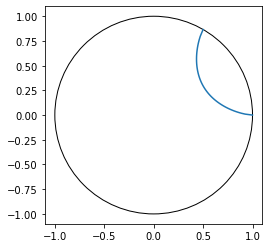

In [16]:
# Laskentapisteiden määrä.
N = 100
phi0 = 5 / 15 * np.pi
phi1 = 0
PHI = np.linspace(phi0, phi1, N)
r0 = 1
r1 = 1

# Tätä arvoa muutetaan siten, että ratkaisukäyrä löytyy.
C_guess = 0.05

R, C = calculate_R_nwton(PHI, r0, r1, C_guess)

print('C:', C)

X = np.zeros(N)
Y = np.zeros(N)

for i in range(N):
    X[i] = R[i] * np.cos(PHI[i])
    Y[i] = R[i] * np.sin(PHI[i])

fig, ax = plt.subplots()
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_box_aspect(1)
ax.plot(X, Y)
circle = plt.Circle(np.array([0, 0]), radius=1, fill=False)
ax.add_artist(circle)
plt.show()

Piirretään kuvaaja, jossa on 18 ratkaisukäyrää (9 ja toiset 9 peilattuna x-akselin suhteen). Tätä varten kerätään taulukkoon tarvittavat $C$:n arvot, jotka saadaan etsittyä edellisen koodin avulla.

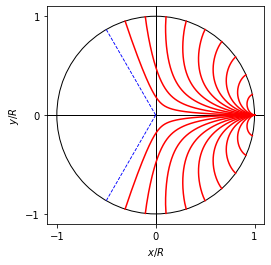

In [42]:
# Laskentapisteiden määrä.
N = 500
r0 = 1
r1 = 1
phi1 = 0

C_table = np.array([0.08707764176969084,
                    0.23663027970424932,
                    0.5068339805258355,
                    1.0292496773763447,
                    2.1383866875547635,
                    4.835323354129922,
                    12.942104764728443,
                    48.47738037880619,
                    425.1650864968066])

fig, ax = plt.subplots()
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_box_aspect(1)
circle = plt.Circle(np.array([0, 0]), radius=1, fill=False)
ax.add_artist(circle)

x_axis = plt.plot(np.linspace(-2, 2, N), np.zeros(N), c='black', linewidth=1)
y_axis = plt.plot(np.zeros(N), np.linspace(-2, 2, N), c='black', linewidth=1)

for i in range(len(C_table)):
    phi0 = (i + 1) / 15 * np.pi
    PHI = np.linspace(phi0, phi1, N)
    R, C = calculate_R_nwton(PHI, r0, r1, C_table[i])
    
    X = np.zeros(N)
    Y = np.zeros(N)

    for i in range(N):
        X[i] = R[i] * np.cos(PHI[i])
        Y[i] = R[i] * np.sin(PHI[i])

    ax.plot(X, Y, c='red')
    ax.plot(X, -Y, c='red')

ax.plot([0, np.cos(2 * np.pi / 3)], [0, np.sin(2 * np.pi / 3)], c='blue', linestyle='dashed', linewidth=0.9)
ax.plot([0, np.cos(2 * np.pi / 3)], [0, -np.sin(2 * np.pi / 3)], c='blue', linestyle='dashed', linewidth=0.9)

plt.xlabel(r"$x/R$")
plt.ylabel(r"$y/R$")
plt.locator_params(nbins=3)
plt.savefig('newton_universaali_painovoimalaki_ratkaisukäyriä.pdf')
plt.show()

## Schwarzschildin metriikan ratkaisukäyrät

C: 2.3652711631905112
r_min: 0.39346399713135394


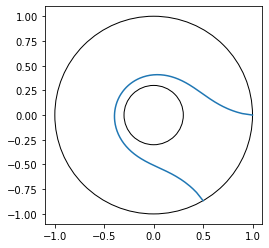

In [44]:
# Laskentapisteiden määrä.
N = 300
phi0 = 5/3*np.pi
phi1 = 0
PHI = np.linspace(phi0, phi1, N)
r0 = 1
r1 = 1
Rs = 0.3

# Tätä arvoa muutetaan siten, että ratkaisukäyrä löytyy.
C_guess = 2.3496837748442205

R, C, r_min = calculate_R_schw(PHI, r0, r1, Rs, C_guess)

print('C:', C)
print('r_min:', r_min)

X = np.zeros(N)
Y = np.zeros(N)

for i in range(N):
    X[i] = R[i] * np.cos(PHI[i])
    Y[i] = R[i] * np.sin(PHI[i])

fig, ax = plt.subplots()
ax.set_xlim(-r0 - 0.1, r0 + 0.1)
ax.set_ylim(-r0 - 0.1, r0 + 0.1)
ax.set_box_aspect(1)
ax.plot(X, Y)
circle = plt.Circle(np.array([0, 0]), radius=r0, fill=False)
Rs_radius = plt.Circle(np.array([0, 0]), radius=Rs, fill=False)
ax.add_artist(circle)
ax.add_artist(Rs_radius)
plt.show()

Piirretään taas kuvaaja, jossa on 30 ratkaisukäyrää (15 ja toiset 15 peilattuna x-akselin suhteen). Tätä varten kerätään taulukkoon tarvittavat $C$:n arvot, jotka saadaan etsittyä edellisen koodin avulla.

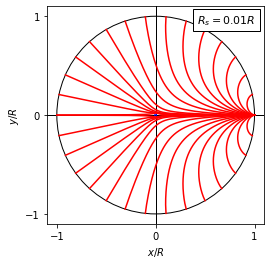

In [40]:
# Laskentapisteiden määrä.
N = 500
r0 = 1
r1 = 1
phi1 = 0
Rs = 0.01

C_table = np.array([0.0008638259003908143,
                    0.0023373904882279554,
                    0.0049747448758991125,
                    0.010003249149788387,
                    0.020445333867481676,
                    0.04487210688989725,
                    0.11283538002287444,
                    0.35913293739822505,
                    1.685317225159851,
                    11.6810280679835,
                    60.48687473249351,
                    164.64444488314433,
                    298.68558666864453,
                    434.64742290294726,
                    557.2569038424251])

fig, ax = plt.subplots()
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_box_aspect(1)
circle = plt.Circle(np.array([0, 0]), radius=1, fill=False)
Rs_radius = plt.Circle(np.array([0, 0]), radius=Rs, fill=False, edgecolor='blue', zorder=5)
ax.add_artist(circle)
ax.add_artist(Rs_radius)

x_axis = plt.plot(np.linspace(-2, 2, N), np.zeros(N), c='black', linewidth=1, zorder=0)
y_axis = plt.plot(np.zeros(N), np.linspace(-2, 2, N), c='black', linewidth=1, zorder=0)

for i in range(len(C_table)):
    phi0 = (i + 1) / 15 * np.pi
    PHI = np.linspace(phi0, phi1, N)
    R, C, r_min = calculate_R_schw(PHI, r0, r1, Rs, C_table[i])

    X = np.zeros(N)
    Y = np.zeros(N)

    for j in range(N):
        X[j] = R[j] * np.cos(PHI[j])
        Y[j] = R[j] * np.sin(PHI[j])

    ax.plot(X, Y, c='red', zorder=10)
    ax.plot(X, -Y, c='red', zorder=10)

plt.xlabel(r"$x/R$")
plt.ylabel(r"$y/R$")
plt.locator_params(nbins=3)
ax.text(0.42, 0.93, r'$R_s = 0.01R$', fontsize=11, bbox=dict(facecolor='white', alpha=1), zorder=15)
plt.savefig('schw_metriikka_ratkaisukäyriä_Rs_0.01.pdf')
plt.show()

## Metodien vertailu

Piirretään yhden aloitus- ja lopetuspisteen välille ratkaisukäyriä Newtonilaisessa gravitaatiossa ja Schwarzschildin metriikassa. Newtonilaisessa gravitaatiossa ratkaisukäyrä on yksikäsitteinen, kun taas Schwarzschildin metriikassa ratkaisukäyrä riippuu Schwarzschildin säteestä.

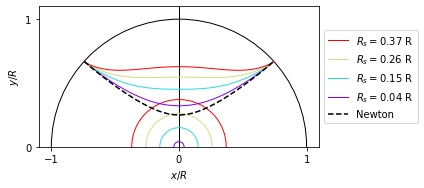

In [55]:
# Laskentapisteiden määrä.
N = 500
r0 = 1
r1 = 1

delta_phi = 8 * np.pi / 15
phi_center = np.pi / 2
phi0 = phi_center + delta_phi / 2
phi1 = phi_center - delta_phi / 2
PHI = np.linspace(phi0, phi1, N)

fig, ax = plt.subplots()
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(0, 1.1)
ax.set_aspect('equal')
ax.set_yticks(range(0, 2))

# Newtonilainen gravitaatio.
C_guess = 0.08707764176969084
R, C = calculate_R_nwton(PHI, r0, r1, C_guess)
X = np.zeros(N)
Y = np.zeros(N)

for i in range(N):
    X[i] = R[i] * np.cos(PHI[i])
    Y[i] = R[i] * np.sin(PHI[i])

ax.plot(X, Y, c='black', zorder=10, label='Newton', linestyle='dashed')

# Schwarzschildin metriikka.
N_Rs = 4
Rs_table = np.zeros(N_Rs)
Rs_min = 0.04
Rs_max = 0.37
Rs_dif = (Rs_max - Rs_min) / (N_Rs - 1)

for i in range(N_Rs):
    Rs_table[i] = Rs_min + i * Rs_dif
    
C_table = np.array([17.891920171065962, 4.007893010438802, 1.4577642746541644, 0.6174774882663305])

color_gen = iter(cm.rainbow(np.linspace(0, 1, len(Rs_table))))
labels = np.array([])

for i in range(N_Rs):
    label = r'$R_s = $' + str(Rs_table[i]) + ' R'
    labels = np.append(labels, label)

for i in range(N_Rs):
    R, C, r_min = calculate_R_schw(PHI, r0, r1, Rs_table[i], C_table[i])
    X = np.zeros(N)
    Y = np.zeros(N)

    for j in range(N):
        X[j] = R[j] * np.cos(PHI[j])
        Y[j] = R[j] * np.sin(PHI[j])
    
    color = next(color_gen)

    ax.plot(X, Y, c=color, linewidth=1, zorder=5, label=labels[i])
    Rs_radius = plt.Circle(np.array([0, 0]), radius=Rs_table[i], fill=False, edgecolor=color)
    ax.add_artist(Rs_radius)

circle = plt.Circle(np.array([0, 0]), radius=1, fill=False)
ax.add_artist(circle)

x_axis = plt.plot(np.linspace(-2, 2, N), np.zeros(N), c='black', linewidth=1, zorder=0)
y_axis = plt.plot(np.zeros(N), np.linspace(-2, 2, N), c='black', linewidth=1, zorder=0)

legend = ax.legend()

handles, labels = legend.axes.get_legend_handles_labels()
handles_reordered = np.array([])
labels_reordered = np.array([])

for i in range(len(handles)):
    handles_reordered = np.append(handles_reordered, handles[-1 - i])
    labels_reordered = np.append(labels_reordered, labels[-1 - i])

plt.xlabel(r"$x/R$")
plt.ylabel(r"$y/R$")
plt.locator_params(nbins=3)
legend = ax.legend(handles_reordered, labels_reordered, loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.savefig('Metodien_vertailua.pdf', bbox_inches='tight')
plt.show()